#CNNs & Autoencoders

#Prequisites
Please install Python and required libraries for this exercise, or do it in google colab.


In [32]:
# These are the libraries that we used - feel free to use others if you want
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.datasets import load_digits
from sklearn.model_selection import train_test_split
import numpy as np
import matplotlib.pyplot as plt
from torchvision import transforms
from PIL import Image
import torch.nn.functional as F

# 1.
 Implement the convolution function `conv(x, kernel, stride, pad)`, where:

- `x`: A two-dimensional array of size `(W, H)`.
- `kernel`: Convolution kernel of size `(K, K)`.
- `stride`: The stride of the convolution kernel. 0 <stride ≤ min(W,H) .
- `pad`: Padding width applied to each side of the array. pad > 0.

The output of the function should return the following value:

- `out`: The result of convolving the input data `x`, which has dimensions `(H', W')`:

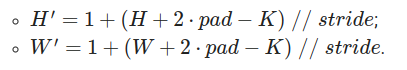

Utilize the created function `conv` to apply the Sobel operator to an image, then display the result on the screen.

You may use either `numpy` or `torch`, as you prefer. (8 points)

In [33]:
# train example
a = np.arange(9).reshape((3, 3))
M = np.block([[a, a],[a, a]])
print(M)

[[0 1 2 0 1 2]
 [3 4 5 3 4 5]
 [6 7 8 6 7 8]
 [0 1 2 0 1 2]
 [3 4 5 3 4 5]
 [6 7 8 6 7 8]]


In [34]:
def conv(x, kernel, stride, pad):
    return F.conv2d(x, kernel, stride=stride, padding=pad)


In [35]:
sobel_kernel_vert = torch.tensor([
    [-1., 0., 1.],
    [-2., 0., 2.],
    [-1., 0., 1.]
]).view(1, 1, 3, 3)   # <-- Make it 4D: [1,1,3,3]

sobel_kernel_hor = torch.tensor([
    [-1., -2., -1.],
    [ 0.,  0.,  0.],
    [ 1.,  2.,  1.]
]).view(1, 1, 3, 3)


In [36]:
# Apply convolution
x = torch.tensor(M, dtype=torch.float32).unsqueeze(0).unsqueeze(0)

grad_x = conv(x, sobel_kernel_vert, stride=1, pad=1)
grad_y = conv(x, sobel_kernel_hor, stride=1, pad=1)
grad = torch.sqrt(grad_x**2 + grad_y**2)


Apply this two filters to the next image and plot the results:

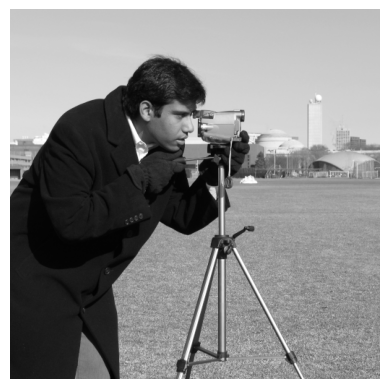

In [37]:
from skimage import data

camera = data.camera()
plt.figure()
plt.imshow(camera.astype("int"), cmap="gray", vmin=0, vmax=255)
plt.axis("off");

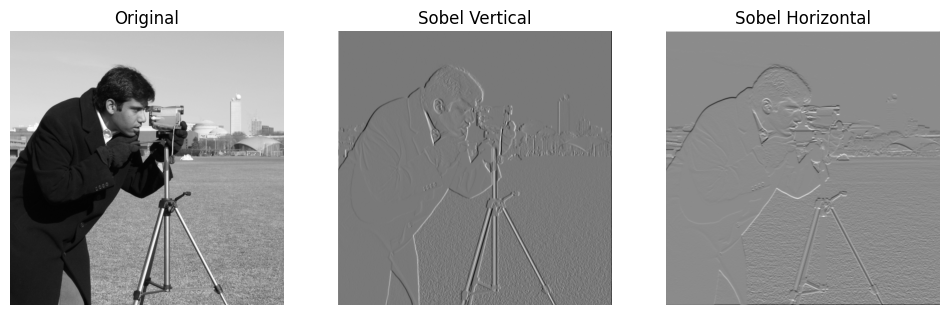

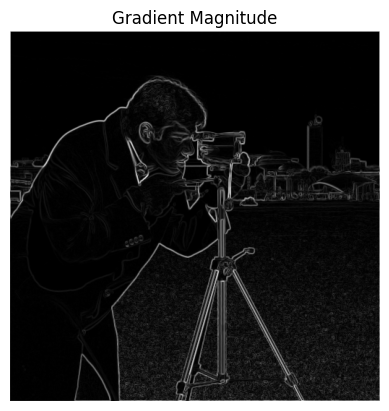

In [38]:
# Apply Sobel filters
# Convert the image to a tensor
x = torch.tensor(camera, dtype=torch.float32).unsqueeze(0).unsqueeze(0)  # [1,1,H,W]

# Apply vertical and horizontal Sobel filters
grad_x = conv(x, sobel_kernel_vert, stride=1, pad=1)
grad_y = conv(x, sobel_kernel_hor, stride=1, pad=1)

# Compute gradient magnitude
grad = torch.sqrt(grad_x**2 + grad_y**2)


# Display results
plt.figure(figsize=(12,4))

plt.subplot(1,3,1)
plt.imshow(camera, cmap='gray')
plt.title('Original')
plt.axis('off')

plt.subplot(1,3,2)
plt.imshow(grad_x.squeeze().detach().numpy(), cmap='gray')
plt.title('Sobel Vertical')
plt.axis('off')

plt.subplot(1,3,3)
plt.imshow(grad_y.squeeze().detach().numpy(), cmap='gray')
plt.title('Sobel Horizontal')
plt.axis('off')

plt.figure()
plt.imshow(grad.squeeze().detach().numpy(), cmap='gray')
plt.title('Gradient Magnitude')
plt.axis('off')
plt.show()


#2.
Train an autoencoder to reconstruct images of digits with the following properties:
- **Encoder**: X pixels → 32 → 8 dimensions
- **Decoder**: Reconstructs 8 → 32 → X pixels

The bottleneck (8 dimensions) forces the network to learn a compressed representation. Then inspect the reconstructed images. (10 points)

In [39]:
# Load data
digits = load_digits()
X = digits.data / 16.0  # Normalize to [0, 1]
y = digits.target

# Check the dimensionality of the images to be able to set the layer dimensions accordingly later on

print("Data shape:", X.shape)
print("Each image is 8x8 =", 8*8)

Data shape: (1797, 64)
Each image is 8x8 = 64


Train shape: torch.Size([1437, 64])
Test shape: torch.Size([360, 64])


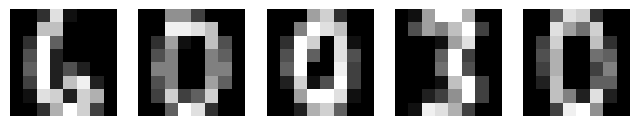

In [40]:
# Split into train and test

# Split dataset
X_train, X_test = train_test_split(X, test_size=0.2, random_state=42)

# Convert to PyTorch tensors
X_train = torch.tensor(X_train, dtype=torch.float32)
X_test = torch.tensor(X_test, dtype=torch.float32)


print("Train shape:", X_train.shape)
print("Test shape:", X_test.shape)

# Visualize some samples (you need to reshape them 8x8 images)

plt.figure(figsize=(8,2))
for i in range(5):
    plt.subplot(1,5,i+1)
    plt.imshow(X_train[i].reshape(8,8), cmap='gray')
    plt.axis('off')
plt.show()



In [41]:
class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, 8),   # bottleneck
            nn.ReLU()
        )
        self.decoder = nn.Sequential(
            nn.Linear(8, 32),
            nn.ReLU(),
            nn.Linear(32, 64),
            nn.Sigmoid()
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

model = Autoencoder()
print(model)


Autoencoder(
  (encoder): Sequential(
    (0): Linear(in_features=64, out_features=32, bias=True)
    (1): ReLU()
    (2): Linear(in_features=32, out_features=8, bias=True)
    (3): ReLU()
  )
  (decoder): Sequential(
    (0): Linear(in_features=8, out_features=32, bias=True)
    (1): ReLU()
    (2): Linear(in_features=32, out_features=64, bias=True)
    (3): Sigmoid()
  )
)


In [42]:
# Train the model using the MSE reconstruction loss and the Adam optimizer.
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)

epochs = 50
for epoch in range(epochs):
    output = model(X_train)
    loss = criterion(output, X_train)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if (epoch+1) % 10 == 0:
        print(f"Epoch [{epoch+1}/{epochs}], Loss: {loss.item():.6f}")


Epoch [10/50], Loss: 0.084131
Epoch [20/50], Loss: 0.077891
Epoch [30/50], Loss: 0.074257
Epoch [40/50], Loss: 0.069552
Epoch [50/50], Loss: 0.060100


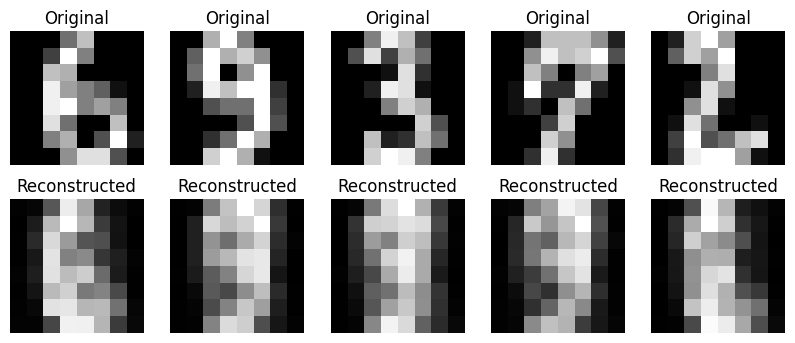

In [43]:
# Compare original test images with their reconstructions to see how well the autoencoder learned to compress and reconstruct.

# Reconstruct the test images

# Visualize original vs reconstructed

model.eval()
with torch.no_grad():
    reconstructed = model(X_test)

plt.figure(figsize=(10,4))
for i in range(5):
    # Original
    plt.subplot(2,5,i+1)
    plt.imshow(X_test[i].reshape(8,8), cmap='gray')
    plt.title("Original")
    plt.axis('off')

    # Reconstructed
    plt.subplot(2,5,5+i+1)
    plt.imshow(reconstructed[i].reshape(8,8), cmap='gray')
    plt.title("Reconstructed")
    plt.axis('off')

plt.show()
